In [1]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import numpy as np
import scipy.linalg as la

from rbf import *
from scipy.spatial import cKDTree

In [2]:
matplotlib.rcParams.update({'font.size': 14})

In [3]:
rbf_obj = rbf_dict['multiquadric']
rbf = rbf_obj['rbf']

gaussian


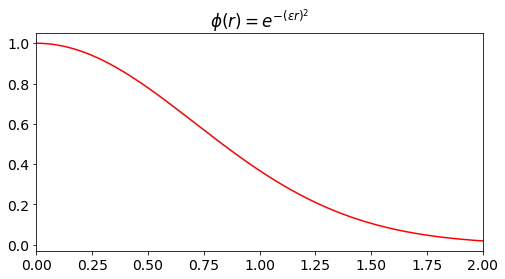

multiquadric


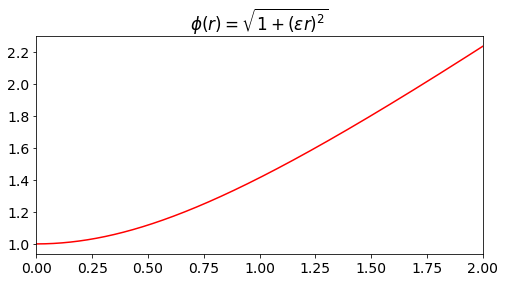

inverse quadratic


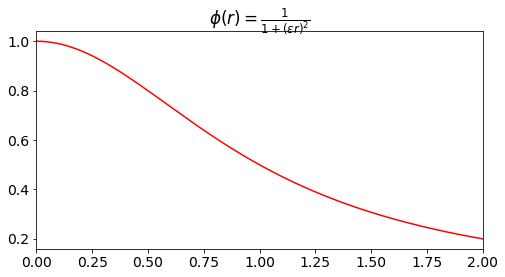

inverse multiquadric


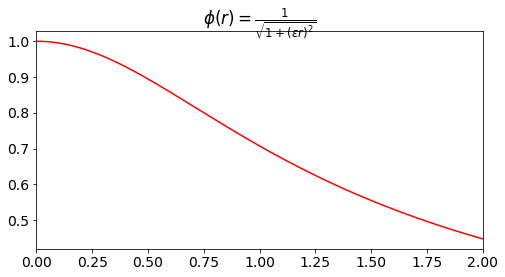

thin plate spline


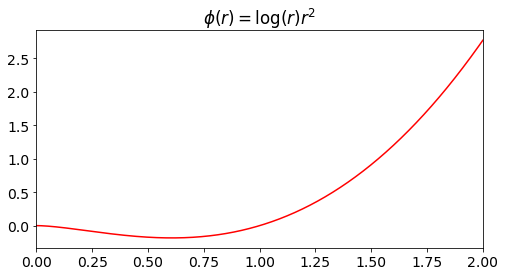

cubic spline


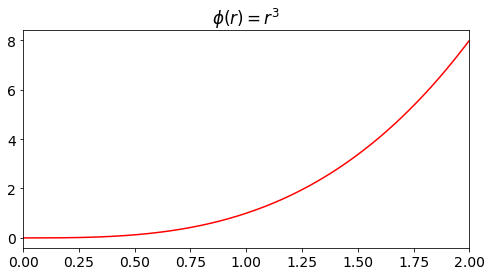

fourth degree PHS


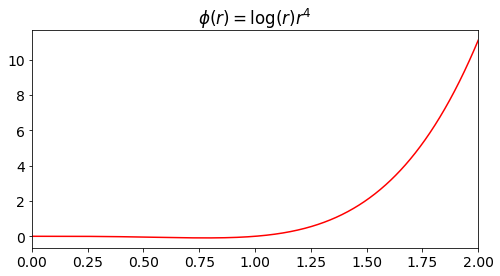

fith degree PHS


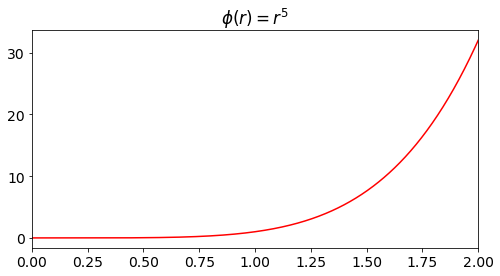

sixth degree PHS


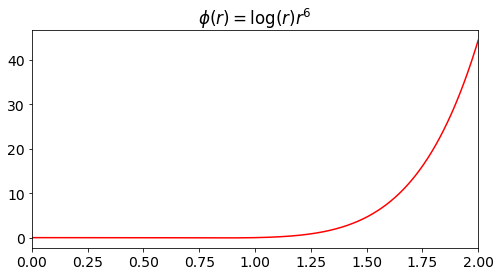

seventh degree PHS


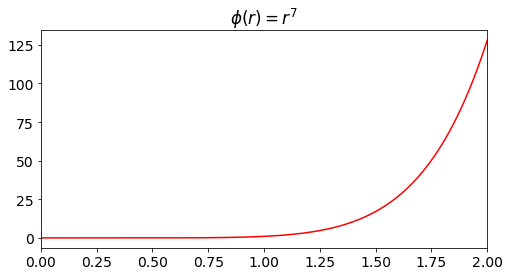

eighth degree PHS


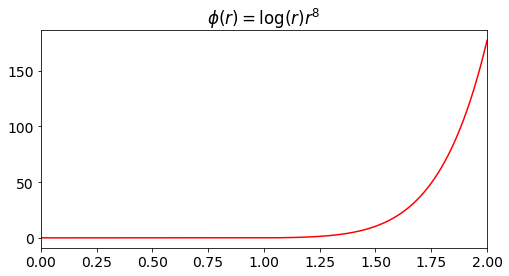

ninth degree PHS


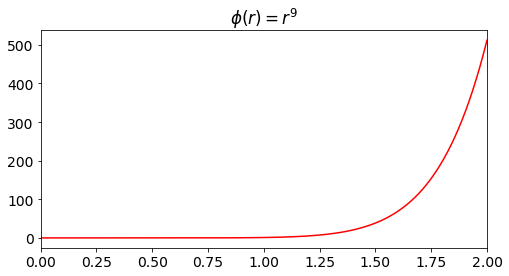

In [4]:
a, b = 0, 2
xs = np.linspace(a, b, 1000)
for label in rbf_labels:
    print(label)
    rbf_obj = rbf_dict[label]
    rbf = rbf_obj['rbf']
    plt.figure(figsize=(8,4))
    plt.plot(xs, rbf(xs, 1), 'r-')
    plt.title('$\phi(r) = $' + rbf_obj['tex'])
    plt.xlim(a,b)
    plt.show()

# Interpolation

In [5]:
def foo(x):
    return np.sin(np.exp(3*x))

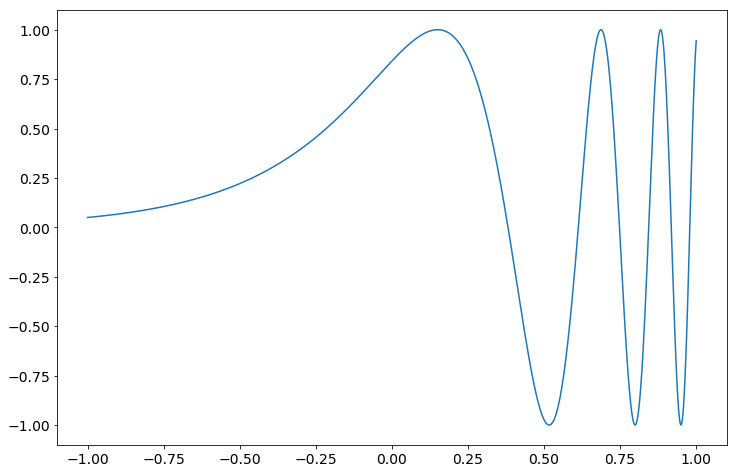

In [6]:
a, b = -1, 1
xs = np.linspace(a, b, 10**3)
plt.figure(figsize=(12,8))
plt.plot(xs, foo(xs))
plt.show()

In [7]:
ns = [8*2**i for i in range(7)]
print(ns)

shape_errors = [[] for label in shape_labels]
phs_errors = [[] for label in phs_labels]
for n in ns:
    print('calculating for n=%d' % n)
    xs = np.linspace(a, b, n)
    zs = np.linspace(a, b, n*3)
    fs = foo(xs)
    u_true = foo(zs)
    for i, label in enumerate(shape_labels):
        rbf_obj = rbf_dict[label]
        rbf = rbf_obj['rbf']
        us, *junk = rbf_interp(xs, fs, zs, rbf, optimize_shape=True)
        err = la.norm(us-u_true)/la.norm(u_true)
        shape_errors[i].append(err)
    for i, label in enumerate(phs_labels):
        rbf_obj = rbf_dict[label]
        rbf = rbf_obj['rbf']
        us, *junk = rbf_interp(xs, fs, zs, rbf, optimize_shape=False)
        err = la.norm(us-u_true)/la.norm(u_true)
        phs_errors[i].append(err)

[8, 16, 32, 64, 128, 256, 512]
calculating for n=8
calculating for n=16
calculating for n=32
calculating for n=64
calculating for n=128
calculating for n=256
calculating for n=512


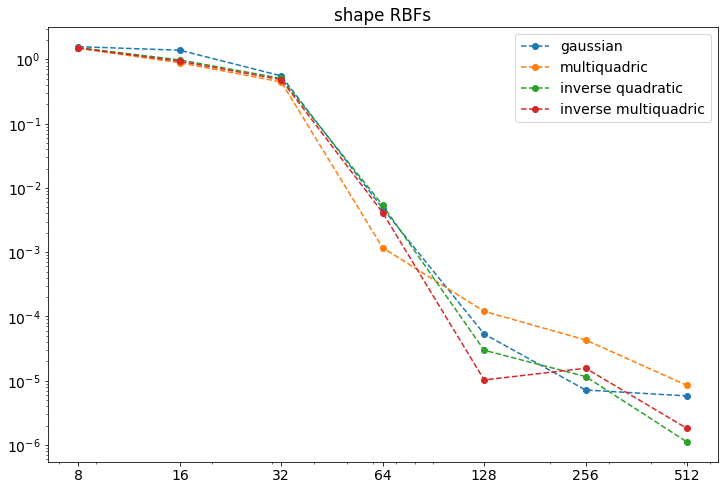

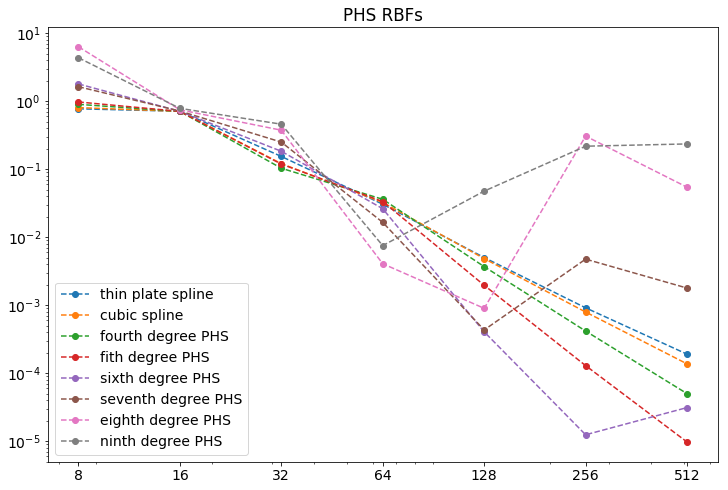

In [8]:
plt.figure(figsize=(12,8))
legend = []
for err, label in zip(shape_errors, shape_labels):
    plt.loglog(ns, err, 'o--')
    legend.append(label)
plt.legend(legend)
plt.xticks(ns, ns)
plt.title('shape RBFs')
plt.show()

plt.figure(figsize=(12,8))
legend = []
for err, label in zip(phs_errors, phs_labels):
    plt.loglog(ns, err, 'o--')
    legend.append(label)
plt.legend(legend)
plt.xticks(ns, ns)
plt.title('PHS RBFs')
plt.show()

# Local Interpolation

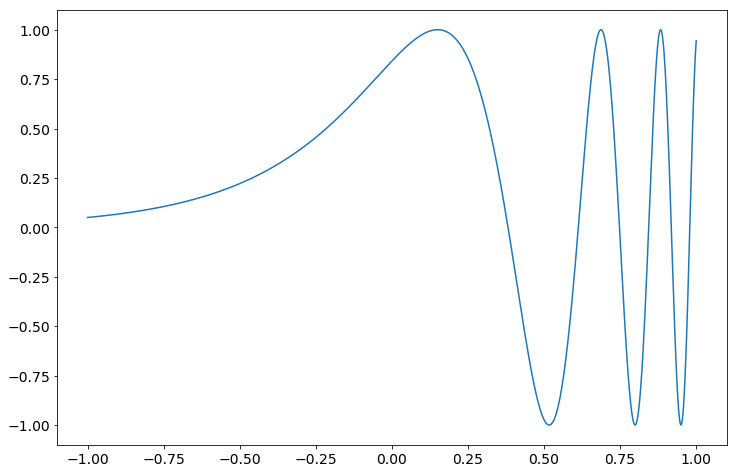

In [5]:
def foo(x):
    #return np.sin(2*np.pi*x)
    return np.sin(np.exp(3*x))

a, b = -1, 1
xs = np.linspace(a, b, 10**3)
plt.figure(figsize=(12,8))
plt.plot(xs, foo(xs))
plt.show()

In [6]:
n, k = 15, 5
m = n*10
rbf_label = 'multiquadric'
eps = 2

#################################################
rbf_obj = rbf_dict[rbf_label]
rbf = rbf_obj['rbf']
xs = np.linspace(a,b,n)
zs = np.linspace(a,b,m)
u_true = foo(zs)
u = np.zeros(len(zs))

all_weights = np.zeros((n,k))
stencils = np.zeros((n,k))
for i in range(k//2+1):
    stencils[i] = xs[:k]
for i in range(k//2+1, n -k//2):
    stencils[i] = xs[i-(k//2):i+(k//2+1)]
for i in range(n -k//2, n):
    stencils[i] = xs[-k:]
    
for i, z in enumerate(zs):
    center = np.argmin(np.abs(xs-z))
    stencil = stencils[center]
    fs = foo(stencil)
    dist_mat = np.abs(np.subtract.outer(stencil,stencil))
    A = rbf(dist_mat, eps)
    cs = la.solve(A, fs)
    
    u[i] = np.dot(rbf(np.abs(stencil-z),eps), cs)

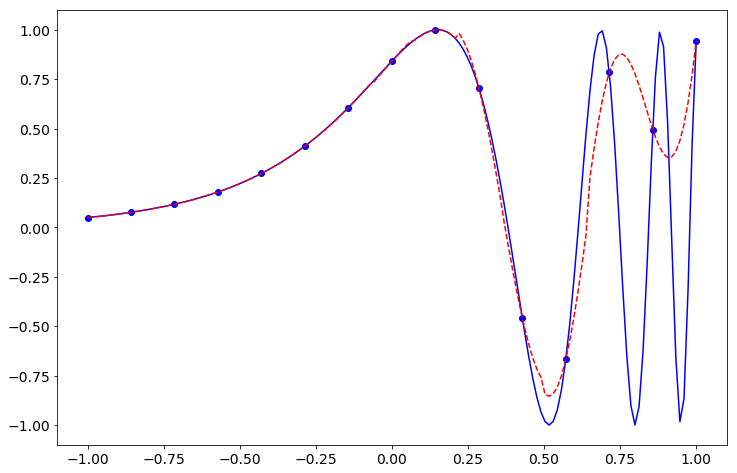

In [7]:
plt.figure(figsize=(12,8))
plt.plot(xs, foo(xs), 'bo')
plt.plot(zs, u_true, 'b-')
plt.plot(zs, u, 'r--')
plt.show()

In [8]:
n, k = 100, 21
m = n*10
rbf_label = 'multiquadric'
#eps = 5

#################################################
# make k odd for simplicity
if k%2==0:
    k += 1
rbf_obj = rbf_dict[rbf_label]
rbf = rbf_obj['rbf']
xs = np.linspace(a,b,n)
fs = foo(xs)
zs = np.linspace(a,b,m)
u_true = foo(zs)
us = np.zeros(len(zs))

full_dist_mat = np.abs(np.subtract.outer(zs,xs))
closest_ids = np.argmin(full_dist_mat, axis=1)
# in a zoop build surface around each sample point
for i in range(len(xs)):
    c = xs[i]
    close_to_c_ids = closest_ids == i
    zs_local = zs[close_to_c_ids]
    x_ids = get_closest_indices(i, len(xs), k)
    xs_local = xs[x_ids]
    fs_local = fs[x_ids]
    dist_mat = np.abs(np.subtract.outer(xs_local,xs_local))
    eps = optimize_eps(rbf, dist_mat)
    A = rbf(dist_mat, eps)
    cs = la.solve(A, fs_local)
    dist_mat = np.abs(np.subtract.outer(zs_local,xs_local))
    A = rbf(dist_mat, eps)
    us_local = A @ cs
    us[close_to_c_ids] = us_local
    

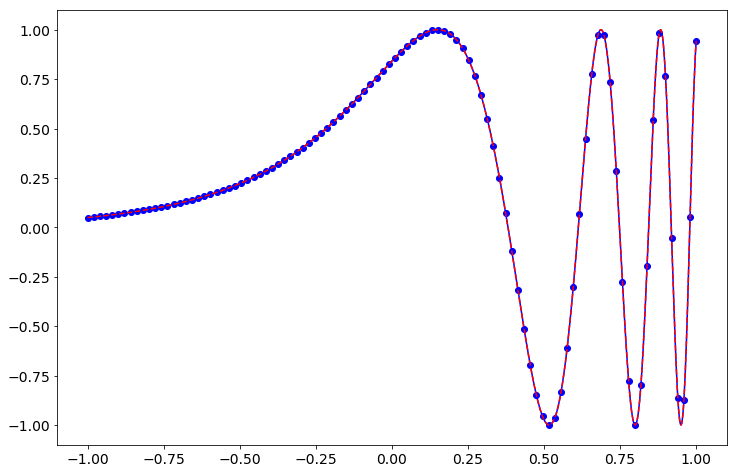

In [9]:
plt.figure(figsize=(12,8))
plt.plot(xs, fs, 'bo')
plt.plot(zs, u_true, 'b-')
plt.plot(zs, us, 'r--')
plt.show()

In [10]:
k = 39
ns = [40*2**i for i in range(6)]
print(ns)

shape_errors = [[] for label in shape_labels]
phs_errors = [[] for label in phs_labels]
for n in ns:
    print('calculating for n=%d' % n)
    xs = np.linspace(a, b, n)
    zs = np.linspace(a, b, n*3)
    fs = foo(xs)
    u_true = foo(zs)
    for i, label in enumerate(shape_labels):
        rbf_obj = rbf_dict[label]
        rbf = rbf_obj['rbf']
        us = rbf_interp_local_1D(xs, fs, zs, rbf, stencil_size=k, optimize_shape=True)
        err = la.norm(us-u_true)/la.norm(u_true)
        shape_errors[i].append(err)
    for i, label in enumerate(phs_labels):
        rbf_obj = rbf_dict[label]
        rbf = rbf_obj['rbf']
        us = rbf_interp_local_1D(xs, fs, zs, rbf, stencil_size=k, optimize_shape=False)
        err = la.norm(us-u_true)/la.norm(u_true)
        phs_errors[i].append(err)

[40, 80, 160, 320, 640, 1280]
calculating for n=40
calculating for n=80
calculating for n=160
calculating for n=320
calculating for n=640
calculating for n=1280


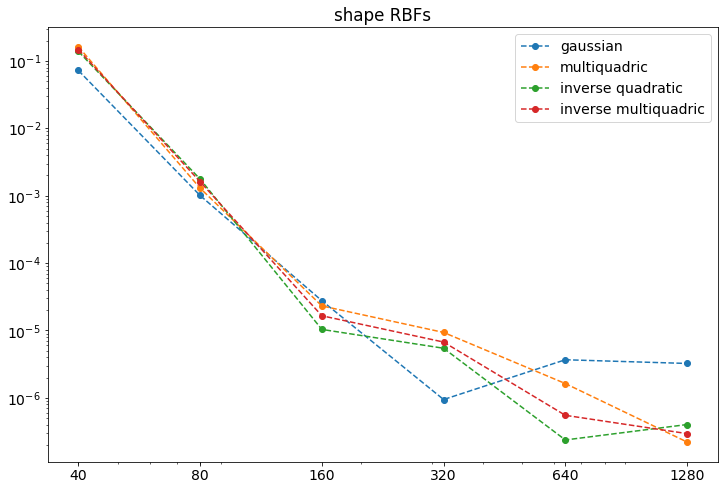

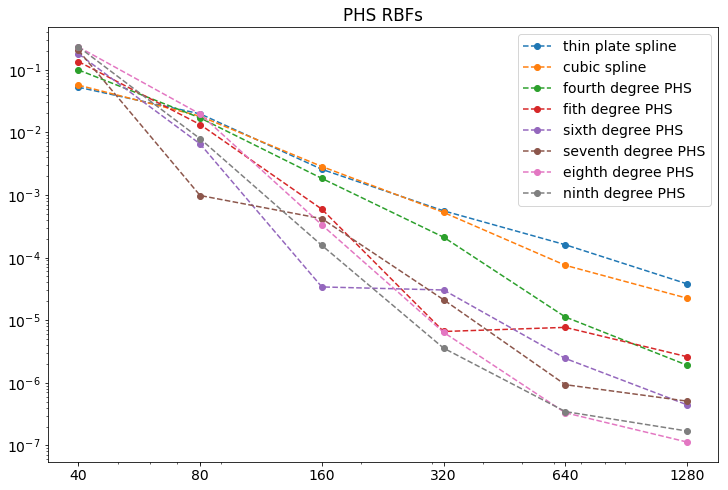

In [11]:
plt.figure(figsize=(12,8))
legend = []
for err, label in zip(shape_errors, shape_labels):
    plt.loglog(ns, err, 'o--')
    legend.append(label)
plt.legend(legend)
plt.xticks(ns, ns)
plt.title('shape RBFs')
plt.show()

plt.figure(figsize=(12,8))
legend = []
for err, label in zip(phs_errors, phs_labels):
    plt.loglog(ns, err, 'o--')
    legend.append(label)
plt.legend(legend)
plt.xticks(ns, ns)
plt.title('PHS RBFs')
plt.show()

In [86]:
def rbf_interp_local_1D(xs, fs, zs, rbf, stencil_size=10, eps=1, optimize_shape=False, target_cond=10**12, return_cond=False):
    k = stencil_size    
    us = np.zeros(len(zs))
    full_dist_mat = np.abs(np.subtract.outer(zs,xs))
    closest_ids = np.argmin(full_dist_mat, axis=1)
    # in a zoop build surface around each sample point
    for i in range(len(xs)):
        c = xs[i]
        close_to_c_ids = closest_ids == i
        zs_local = zs[close_to_c_ids]
        x_ids = get_closest_indices(i, len(xs), k)
        xs_local = xs[x_ids]
        fs_local = fs[x_ids]
        dist_mat = np.abs(np.subtract.outer(xs_local,xs_local))
        if optimize_shape:
            eps = optimize_eps(rbf, dist_mat)
        A = rbf(dist_mat, eps)
        cs = la.solve(A, fs_local)
        dist_mat = np.abs(np.subtract.outer(zs_local,xs_local))
        A = rbf(dist_mat, eps)
        us_local = A @ cs
        us[close_to_c_ids] = us_local
    return us

In [85]:
us = rbf_interp_local_1D(xs, fs, zs, rbf, stencil_size=k, optimize_shape=True)

ValueError: f(a) and f(b) must have different signs

In [89]:
def functional(eps, rbf, dist_mat, P, target_cond):
    #print('test2')
    A = rbf(dist_mat, eps)
    if P is None:
        AP = A
    else:
        k = len(P)
        AP = np.block([[A, P],[P.T, np.zeros((k,k))]])
    #print(np.log( la.cond(AP) / target_cond))
    return np.log( la.cond(AP) / target_cond)

def optimize_eps(rbf, dist_mat, P=None, target_cond=10**12):
    #f = open('test.pickle', 'wb')
    #pickle.dump(dist_mat, f)
    #f.close()
    n = dist_mat.shape[0]
    eps_guess = 1/np.min(dist_mat+np.diag([np.max(dist_mat)]*n))
    #eps_guess = 10**5
    #try:
    root = brentq(functional, 
            MEPS, eps_guess*10,
            args=(rbf, dist_mat, P, target_cond))
    #except ValueError:
    #    root = eps_guess
    return root

In [49]:
dist_mat.shape

(6, 21)

In [53]:
import pickle

In [71]:
f = open('test.pickle', 'rb')
dist_mat = pickle.load(f)
f.close()


In [78]:
A = rbf(dist_mat, 10**-10)
print(la.cond(A))

10788.152790574224


In [80]:
rbf

<function rbf.rbf>

In [70]:
xs.shape

(39, 39)

In [81]:
label

'thin plate spline'

In [1]:
from sympy import *

In [60]:
r, eps = symbols('r eps')
phi = r**9

In [61]:
expr = phi
for name in ['zeta', 'chi', 'beta']:
    expr = (diff(expr, r)/r).simplify()
    expr_str = str(expr).replace('exp','np.exp')
    expr_str = expr_str.replace('sqrt', 'np.sqrt')
    expr_str = expr_str.replace('log(', 'np.log(MEPS + ')
    print('def %s(r, eps):\n\treturn %s' % (name, expr_str))
    
expr = phi
for name in ['drbf', 'd2rbf']:
    expr = diff(expr, r).simplify()
    expr_str = str(expr).replace('exp','np.exp')
    expr_str = expr_str.replace('sqrt', 'np.sqrt')
    expr_str = expr_str.replace('log(', 'np.log(MEPS + ')
    print('def %s(r, eps):\n\treturn %s' % (name, expr_str))


def zeta(r, eps):
	return 9*r**7
def chi(r, eps):
	return 63*r**5
def beta(r, eps):
	return 315*r**3
def drbf(r, eps):
	return 9*r**8
def d2rbf(r, eps):
	return 72*r**7


In [41]:
expr = diff(phi,r)/r

In [42]:
expr = expr.simplify()

In [43]:
expr

2*log(r) + 1